In [2]:
import csv
import numpy as np
import os
import scipy.stats
import pandas as pd
import sqlite3 as sql
from scipy.stats import chi2_contingency
%matplotlib inline

# Titanic Data Analysis
## Questions to investigate:

   There are many factors that contributed to an individual on the Titinac's survival. One feature I am intersted in investigating is how family size and composition effected survival rates. Did individuals within larger families have a higher rate of survival? Did parents have a better chance of survival than non-parents. Did children with parents on board have a higher chance of survival than non children?

## Loading the Data
### First I am loading the data into a Pandas Data frame.

In [3]:
cwd = os.getcwd()
data_set = os.path.join(cwd,"titanic.db")
conn = sql.connect(data_set)
titanic = pd.read_sql("select * from titanic;", conn)
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
index          891 non-null int64
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(6), object(5)
memory usage: 90.6+ KB


The Age variable contains NaN. There are a number of ways to handle non numeric values for age. I could come up with methods of imputing a value for age. This could be applying the mean age to all of the records without a age value. I could also impute this value with a more sophisticated regression model. Both of these methods could bias any insights I may find. Instead I will remove these records from my dataset.

In [4]:
titanic.dropna(subset=['Age'], inplace=True) # remove all rows from dataframe with Age value of NA

In [6]:
#The mean of the Survived column gives the survival rate of the passsengers from this dataset.

titanic['Survived'].mean() 

0.4061624649859944

Mr              398
Miss            146
Mrs             108
Master           36
Dr                6
Rev               6
Mlle              2
Col               2
Major             2
Don               1
Lady              1
Capt              1
Ms                1
Sir               1
Mme               1
Jonkheer          1
the Countess      1
Name: Title, dtype: int64

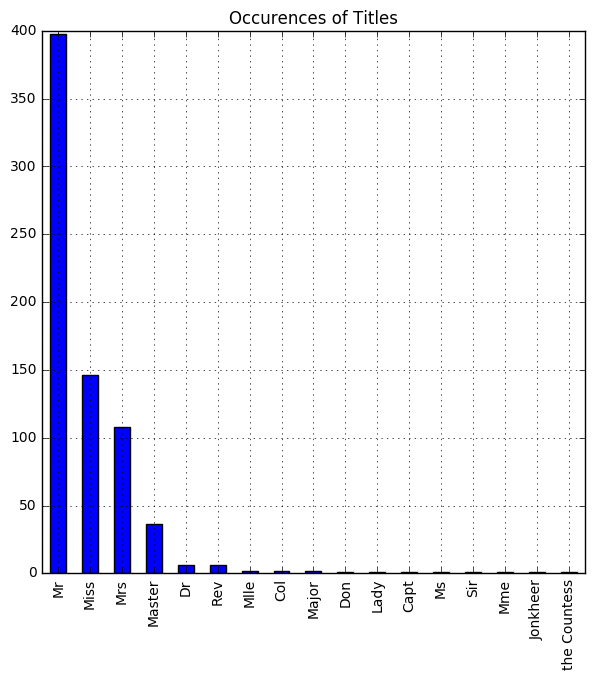

In [10]:

# the format of the Name feature is Last Name, Title. Husband's Given Name (Wife's Maiden Name if applicable)
# lambda function first splits on the comma. It then takes everything from the right of the comma and splits by '.'
# the title should be to the left of the '.'
titanic['Title'] = titanic['Name'].apply(lambda x: x.split(', ')[1].partition('.')[0])
titanic['Title'].value_counts().plot.bar(title ="Occurences of Titles",figsize=(7,7),grid =True)
titanic['Title'].value_counts()


It looks like hte transformation for the new feature worked for all cases on the dataset.
There are a few oddities with the dataset. It appears that the french titles Madame (MME) and Mademoiselle (Mlle) were included. These can be easily mapped to Ms and Mrs. There are a few titles which signs of nobility (ie the Countess and Jonkheer [https://en.wikipedia.org/wiki/Jonkheer])

There is clearly a disproportionate number of Misters vs Miss/Mrs. 

In [11]:

#Checking the number of male vs female passengers to confirm that the difference in Male vs. Female titles makes sense.
Sex = titanic.groupby(by=['Sex'])['Sex'].count()
print(Sex)
# concatenating the "female titles"
Female_Titles = titanic['Title'].value_counts()['Miss']\
+titanic['Title'].value_counts()['Mrs']\
+titanic['Title'].value_counts()['Mlle']\
+titanic['Title'].value_counts()['Ms']\
+titanic['Title'].value_counts()['Jonkheer']\
+titanic['Title'].value_counts()['the Countess']\
+titanic['Title'].value_counts()['Mme']\
+titanic['Title'].value_counts()['Lady']\

print("The number of female titles: {}".format(Female_Titles))

# concatenating the "male titles"
Male_Titles = titanic['Title'].value_counts()['Mr']\
+titanic['Title'].value_counts()['Master']\
+titanic['Title'].value_counts()['Dr']\
+titanic['Title'].value_counts()['Rev']\
+titanic['Title'].value_counts()['Major']\
+titanic['Title'].value_counts()['Col']\
+titanic['Title'].value_counts()['Capt']\
+titanic['Title'].value_counts()['Sir']\
+titanic['Title'].value_counts()['Don']\

print("The number of male titles: {}".format(Male_Titles))


Sex
female    261
male      453
Name: Sex, dtype: int64
The number of female titles: 261
The number of male titles: 453


It looks like the passenger break down by gender and break down by gendered titles are as I would expect.

Next I will investigate how ages are distributed across 

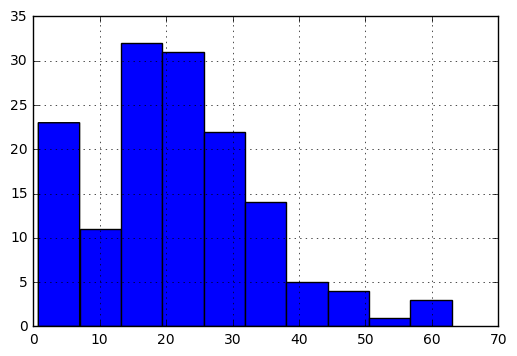

In [26]:
Miss = titanic.loc[titanic['Title']=='Miss']
Miss['Age'].hist()

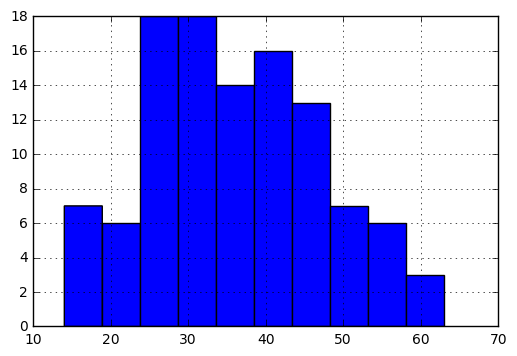

In [27]:
Misses = titanic.loc[titanic['Title']=='Mrs']
Misses['Age'].hist()

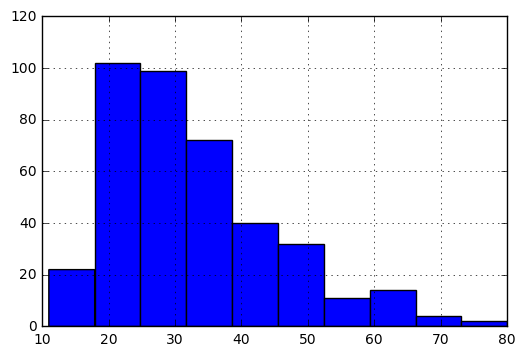

In [24]:
Mister = titanic.loc[titanic['Title']=='Mr']
Mister['Age'].hist()

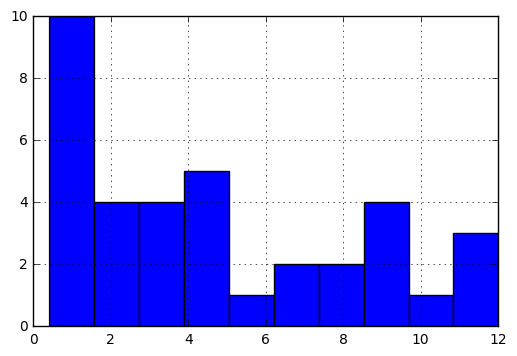

In [20]:
Master = titanic.loc[titanic['Title']=='Master']
Master['Age'].hist()

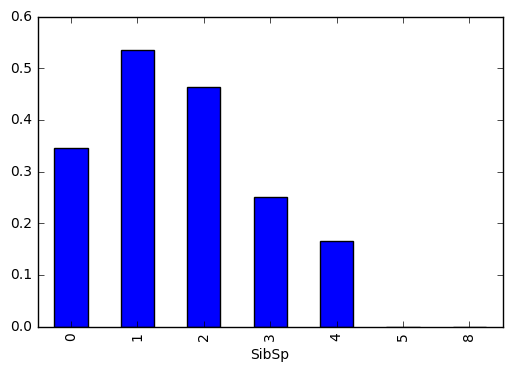

In [34]:
#titanic['SibSp'].value_counts().plot(kind ="bar", title ="Sibling/Spouse Distribution")
titanic[['SibSp','Survived']].groupby("SibSp")['Survived'].agg(np.mean).plot(kind ="bar")

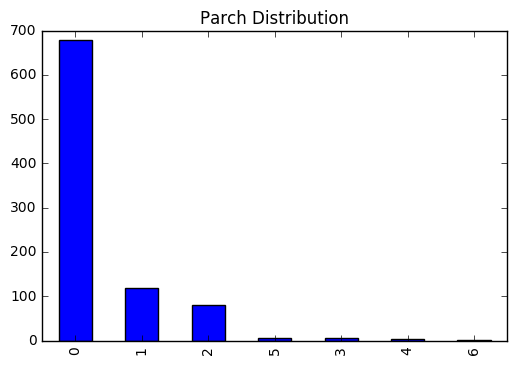

In [42]:
titanic['Parch'].value_counts().plot(kind ="bar", title ="Parch Distribution")

## Looking at the questions which I hope to answer, I see some of the relevant features of the data set are Age, Sex, nd Pclass.

### I will test if there is a significant differents between the survival of males vs the survival of females in the titanic. Formally my hypthosis will be as follows

H<sub>0</sub>: Survival and gender are independent.

H<sub>1</sub>: Survival and geder are not independent.

[<matplotlib.text.Text at 0x11413c450>, <matplotlib.text.Text at 0x114160ad0>]

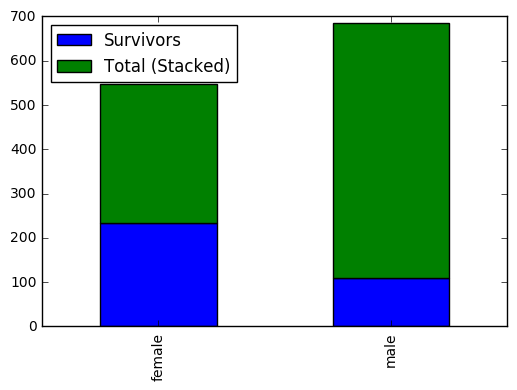

In [3]:
genderDF = pd.read_sql("""
    select
        Sex,
        sum(Survived) as Survivors,
        count(Survived) as "Total (Stacked)"
    from titanic
    group by Sex;
    """, conn)


ax = genderDF.plot(kind="bar", stacked= True)
ax.set_xticklabels(genderDF.Sex)

This graph shows that, while there were fewer females than males, a greater number of females survived than males. I will investigate whether this difference is statistically significant below.

In [16]:
pivot = pd.pivot_table(data = titanic[['Survived', 'Sex']], index = 'Survived', columns = ['Sex'], aggfunc = len)
print pivot
chi2, p_value, dof, expected = chi2_contingency(pivot)
print "Results of Chi-Squared test on Pclass to Survival."
print "Does gender have a significant effect on Survival?"
print "Chi-Squared Score = " + str(chi2)
print "Pvalue = " + str(p_value)
print "\n"

Sex       female  male
Survived              
0             81   468
1            233   109
Results of Chi-Squared test on Pclass to Survival.
Does Pclass have a significant effect on Survival?
Chi-Squared Score = 260.717020167
Pvalue = 1.19735706278e-58




At the 99% confidence level, I must reject H<sub>0</sub> and Accept H<sub>a</sub> that survival and gender are not independent.

### I will test if there is a significant differents between the upper class and other passengers. Formally my hypthosis will be as follows

H<sub>0</sub>: Pclass and Surival rates are independent.

H<sub>1</sub>: Pclass and Survival rates are not independent.

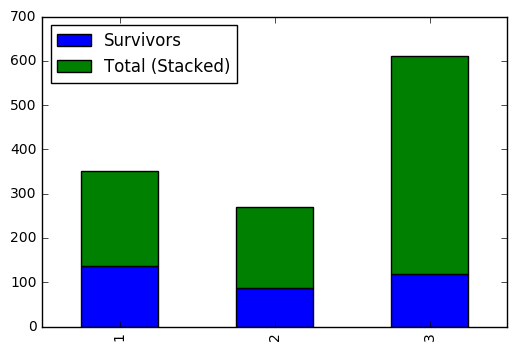

In [8]:
PclassDF = pd.read_sql("""
    select
        Pclass,
        sum(Survived) as Survivors,
        count(Survived) as "Total (Stacked)"
    from titanic
    group by Pclass;
    """, conn)


ax = PclassDF[['Survivors', 'Total (Stacked)']].plot(kind="bar", stacked= True)
ax.set_xticklabels(PclassDF.Pclass)

While third class passengers(which is a proxy for the patient's social standing) have a far greater total than 2nd or 1st class passengers, the number of survivors is roughly the same. I will test if this difference is statistically significant.

In [17]:
lower_class = pd.read_sql("""
    select
        Survived
    from titanic
    where 
        Pclass = 3;
    """, conn)
middle_class = pd.read_sql("""
    select
        Survived
    from titanic
    where 
        Pclass = 2;
    """, conn)
upper_class = pd.read_sql("""
    select
        Survived
    from titanic
    where 
        Pclass = 1;
    """, conn)
print upper_class.describe()
print middle_class.describe()
print lower_class.describe()


         Survived
count  216.000000
mean     0.629630
std      0.484026
min      0.000000
25%      0.000000
50%      1.000000
75%      1.000000
max      1.000000
         Survived
count  184.000000
mean     0.472826
std      0.500623
min      0.000000
25%      0.000000
50%      0.000000
75%      1.000000
max      1.000000
         Survived
count  491.000000
mean     0.242363
std      0.428949
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      1.000000


In [31]:
pivot = pd.pivot_table(data = titanic[['Survived', 'Pclass']], index = 'Survived', columns = ['Pclass'], aggfunc = len)
pivot
print pivot,"\n"


chi2, p_value, dof, expected = chi2_contingency(pivot)
print "Results of Chi-Squared test on Pclass to Survival."
print "Does Pclass have a significant effect on Survival?"
print "Chi-Squared Score = " + str(chi2)
print "Pvalue = " + str(p_value)
print "\n"

Pclass      1   2    3
Survived              
0          80  97  372
1         136  87  119 

Results of Chi-Squared test on Pclass to Survival.
Does Pclass have a significant effect on Survival?
Chi-Squared Score = 102.888988757
Pvalue = 4.5492517113e-23




At the 99% confidence level, I must reject H<sub>0</sub> and Accept H<sub>a</sub> that there is a statistically significant difference in survival rates

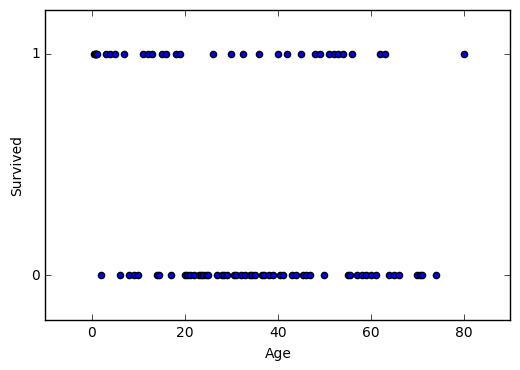

In [36]:
AgeDF = pd.read_sql("""
    select
        Age,
        Survived
    from titanic
    group by Age;
    """, conn)


ax = AgeDF.plot(kind="scatter", x="Age", y="Survived", yticks=[0,1])


### I will test if there is a significant differents between the survival of children vs adults. Formally my hypthosis will be as follows

H<sub>0</sub>: Age and survival are independent.

H<sub>1</sub>: Age and survival are not independent.

In [51]:
titanic['Rounded_Age']=titanic['Age'].apply(lambda x : round(x,-1))
print titanic[['Survived','Rounded_Age','Age']].groupby('Rounded_Age')['Survived'].count()

pivot = pd.pivot_table(data = titanic[['Survived', 'Rounded_Age']], index = 'Survived', columns = ['Rounded_Age'], aggfunc = len, fill_value=0)
pivot
print pivot,"\n"


chi2, p_value, dof, expected = chi2_contingency(pivot)
print "Results of Chi-Squared test on Age to Survival."
print "Does Age have a significant effect on Survival?"
print "Chi-Squared Score = " + str(chi2)
print "Pvalue = " + str(p_value)
print "\n"

Rounded_Age
0.0      40
10.0     38
20.0    200
30.0    201
40.0    120
50.0     73
60.0     31
70.0     10
80.0      1
Name: Survived, dtype: int64
Rounded_Age  0.0   10.0  20.0  30.0  40.0  50.0  60.0  70.0  80.0
Survived                                                         
0              13    20   127   123    69    43    19    10     0
1              27    18    73    78    51    30    12     0     1 

Results of Chi-Squared test on Age to Survival.
Does Age have a significant effect on Survival?
Chi-Squared Score = 22.9142276607
Pvalue = 0.00347613116157




At the 99% confidence level, I must reject H<sub>0</sub> and Accept H<sub>a</sub> that survival and age are not independent.

# Conclusion.

In conclusion, I have found that the scenes depicted in the movie is consistent with the data. Age, gender, and class all seemed to have a statistically significant relationship with the survival rate of passengers on the titanic.